<a href="https://colab.research.google.com/github/CristinaMarsh/100-Days-Of-ML-Code/blob/master/2023/Decomposion_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [7]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP,Autoformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df


In [3]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [10]:
Y_train_df

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364
...,...,...,...,...,...,...
271,Airline2,1959-08-31,859.0,271,805.0,0.136364
272,Airline2,1959-09-30,763.0,272,704.0,0.227273
273,Airline2,1959-10-31,707.0,273,659.0,0.318182
274,Airline2,1959-11-30,662.0,274,610.0,0.409091


In [11]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1960-01-31,417.0,132,360.0,-0.500000
1,Airline1,1960-02-29,391.0,133,342.0,-0.409091
2,Airline1,1960-03-31,419.0,134,406.0,-0.318182
3,Airline1,1960-04-30,461.0,135,396.0,-0.227273
4,Airline1,1960-05-31,472.0,136,420.0,-0.136364
5,Airline1,1960-06-30,535.0,137,472.0,-0.045455
6,Airline1,1960-07-31,622.0,138,548.0,0.045455
7,Airline1,1960-08-31,606.0,139,559.0,0.136364
8,Airline1,1960-09-30,508.0,140,463.0,0.227273
9,Airline1,1960-10-31,461.0,141,407.0,0.318182


In [8]:
model = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)


INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [12]:
nf = NeuralForecast(
    models=[model],
    freq='M'
)

In [13]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [14]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])


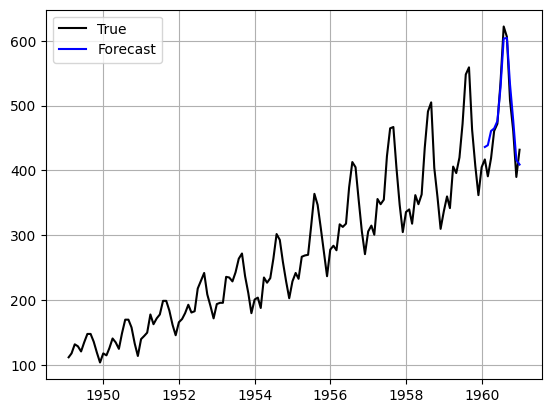

In [15]:
if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:],
                    y1=plot_df['Autoformer-lo-90'][-12:].values,
                    y2=plot_df['Autoformer-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()

In [16]:
model_2 = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MQLoss(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [18]:
nf = NeuralForecast(
    models=[model_2],
    freq='M'
)

In [19]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [25]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

In [26]:
plot_df

,unique_id,ds,y,trend,y_[lag12],month,Autoformer-median,Autoformer-lo-90,Autoformer-lo-80,Autoformer-hi-80,Autoformer-hi-90
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000,NaN,NaN,NaN,NaN,NaN
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091,NaN,NaN,NaN,NaN,NaN
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182,NaN,NaN,NaN,NaN,NaN
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273,NaN,NaN,NaN,NaN,NaN
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19,Airline2,1960-08-31,906.0,283,859.0,0.136364,890.649536,801.556030,818.868042,932.283691,948.978760
20,Airline2,1960-09-30,808.0,284,763.0,0.227273,854.529968,769.118103,786.909607,903.053223,928.079224
21,Airline2,1960-10-31,761.0,285,707.0,0.318182,802.200012,725.654114,746.202820,859.856445,887.262939
22,Airline2,1960-11-30,690.0,286,662.0,0.409091,734.950928,666.910217,687.149170,785.989014,817.196228


[]

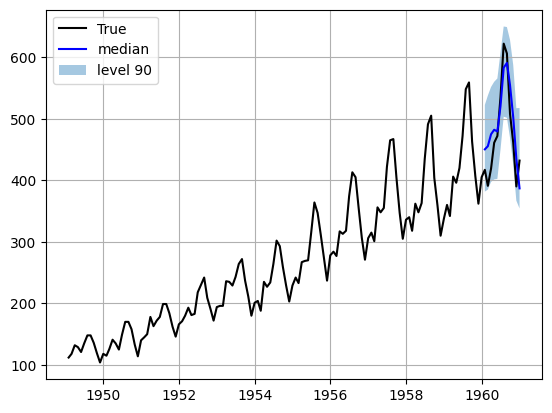

In [27]:
plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['Autoformer-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                y1=plot_df['Autoformer-lo-90'][-12:].values,
                y2=plot_df['Autoformer-hi-90'][-12:].values,
                alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()


# NNHIT


In [29]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, PMM, GMM, NBMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [30]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12,
              input_size=24,
              loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Tweedie', level=[80, 90], rho=1.5),
              #loss=DistributionLoss(distribution='NegativeBinomial', level=[80, 90], return_params=True),
              #loss=NBMM(n_components=2, level=[80,90]),
              #loss=GMM(n_components=2, level=[80,90]),
              #loss=PMM(n_components=1, level=[80,90]),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [31]:
fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

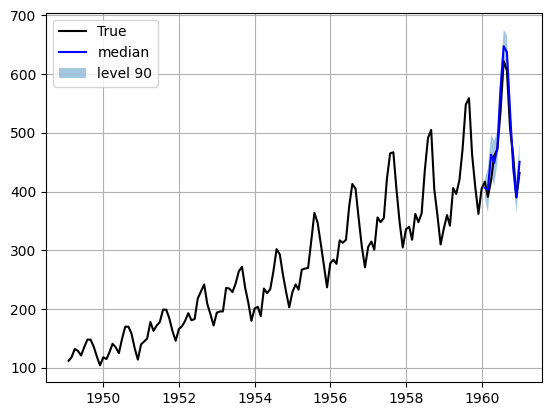

In [32]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NHITS-lo-90'][-12:].values,
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [35]:
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)


# NHITS

In [39]:
Y_train_df

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
259,Airline2,1959-08-31,859.0,271,805.0
260,Airline2,1959-09-30,763.0,272,704.0
261,Airline2,1959-10-31,707.0,273,659.0
262,Airline2,1959-11-30,662.0,274,610.0


In [37]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss, HuberLoss, MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = 1 * (AirPassengersPanel['trend'] % 12) < 2
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [41]:
AirPassengersStatic

,unique_id,airline1,airline2
0,Airline1,0,1
1,Airline2,1,0


In [38]:
model = NHITS(h=12,
              input_size=24,
              #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              loss=HuberLoss(delta=0.5),
              valid_loss=MAE(),
              stat_exog_list=['airline1'],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              val_check_steps=10,
              learning_rate=1e-3)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [40]:
fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

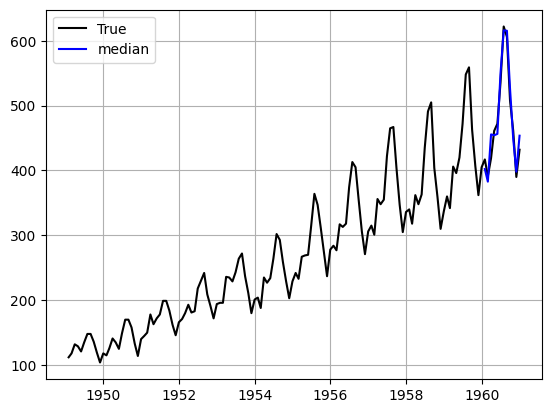

In [42]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='median')
# plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:],
#                  y1=plot_df['NHITS-lo-90'][-12:].values,
#                  y2=plot_df['NHITS-hi-90'][-12:].values,
#                  alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

# Nbeats

In [43]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [44]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [45]:
model = NBEATS(h=12, input_size=24,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)


INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

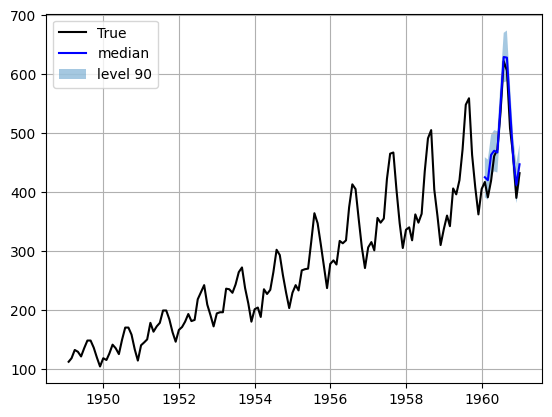

In [46]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NBEATS-lo-90'][-12:].values,
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

# NBEATSx

In [47]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [48]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATSx(h=12, input_size=24,
                #loss=MQLoss(level=[80, 90]),
                loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                scaler_type='robust',
                dropout_prob_theta=0.5,
                stat_exog_list=['airline1'],
                futr_exog_list=['trend'],
                max_steps=200,
                val_check_steps=10,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [49]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

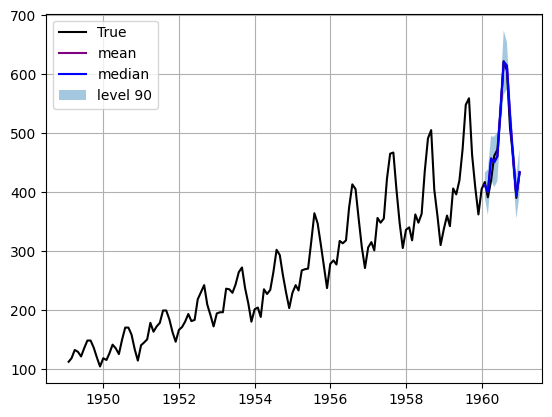

In [50]:
# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATSx'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['NBEATSx-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NBEATSx-lo-90'][-12:].values,
                 y2=plot_df['NBEATSx-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()